# Time filter

In [100]:
import time
import numpy as np
import struct
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Load .pcap data

In [101]:
pcap_path = '../data/late_z_and_p_test.pcap'
# pcap_path = '../data/zelzah_plummer_intersection_12min_032023_lidar.pcap'

In [102]:
packets = rdpcap(pcap_path)

## VLC 32c calibration data

In [103]:
raw_calib_data = [
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -25},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -1},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -1.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -15.639},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -11.31},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 0},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -8.843},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -7.254},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 0.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -0.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -6.148},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -5.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 1.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': 0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -4},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 1.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 1},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -3.667},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -3.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 3.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 2.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -2.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -3},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 7},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -2.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -2},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 15},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 10.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -1.333},
]

In [104]:
# Laser ID mapping for VLP-32C
laser_id_mapping = np.array([
    15, 14, 13, 12, 11, 10, 9, 8,
    7, 6, 5, 4, 3, 2, 1, 0,
    31, 30, 29, 28, 27, 26, 25, 24,
    23, 22, 21, 20, 19, 18, 17, 16
])

In [105]:
focal_distance = 42.4e-3

In [106]:
laser_corrections = []

for i, calib in enumerate(raw_calib_data):
    rot_corr_deg = calib['rot_corr_deg']
    vert_corr_deg = calib['vert_corr_deg']
    rot_correction = np.deg2rad(rot_corr_deg)
    vert_correction = np.deg2rad(vert_corr_deg)
    # Compute vertical offset correction
    vert_offset_correction = focal_distance * np.tan(-vert_correction)
    laser_corrections.append({
        'laser_idx': i,
        'rot_correction': rot_correction,
        'vert_correction': vert_correction,
        'vert_offset_correction': vert_offset_correction
    })
    
for laser in laser_corrections:
    print(laser)

{'laser_idx': 0, 'rot_correction': -0.024434609527920613, 'vert_correction': -0.4363323129985824, 'vert_offset_correction': 0.01977144470577194}
{'laser_idx': 1, 'rot_correction': 0.07330382858376185, 'vert_correction': -0.017453292519943295, 'vert_offset_correction': 0.0007400947529564257}
{'laser_idx': 2, 'rot_correction': -0.024434609527920613, 'vert_correction': -0.029094638630745476, 'vert_offset_correction': 0.00123396087939849}
{'laser_idx': 3, 'rot_correction': 0.024434609527920613, 'vert_correction': -0.2729520417193932, 'vert_offset_correction': 0.011869409247674947}
{'laser_idx': 4, 'rot_correction': -0.024434609527920613, 'vert_correction': -0.19739673840055869, 'vert_offset_correction': 0.008480051969382943}
{'laser_idx': 5, 'rot_correction': 0.024434609527920613, 'vert_correction': 0.0, 'vert_offset_correction': -0.0}
{'laser_idx': 6, 'rot_correction': -0.07330382858376185, 'vert_correction': -0.011641346110802179, 'vert_offset_correction': 0.0004936153737058362}
{'laser_

In [107]:
# def build_timing_offsets():
#     full_firing_cycle = 55.296  # microseconds
#     single_firing = 2.304       # microseconds
#     timing_offsets = np.zeros((12, 32))  # 12 blocks, 32 measurements per block
#     for block_idx in range(12):
#         for measurement_idx in range(32):
#             firing_index = measurement_idx // 2
#             timing_offsets[block_idx, measurement_idx] = (
#                 full_firing_cycle * block_idx + single_firing * firing_index
#             )
#     return timing_offsets  # in microseconds

In [108]:
def build_timing_table(dual_mode=False):
    full_firing_cycle = 55.296  # μs
    single_firing = 2.304       # μs
    num_sequences = 12
    num_firings_per_sequence = 16
    num_data_points_per_sequence = 32  # 32 lasers (16 firings x 2)

    timing_offsets = np.zeros((num_sequences, num_data_points_per_sequence))  # Shape: (12, 32)

    for seq_idx in range(num_sequences):  # SequenceIndex from 0 to 11
        for dp_idx in range(num_data_points_per_sequence):  # DataPointIndex from 0 to 31
            firing_index = dp_idx // 2  # Each firing consists of two lasers
            time_offset = (full_firing_cycle * seq_idx) + (single_firing * firing_index)
            timing_offsets[seq_idx, dp_idx] = time_offset
    return timing_offsets  # in μs

In [109]:
test_timing_table = build_timing_table()
print(test_timing_table)
print(len(test_timing_table))

[[  0.      0.      2.304   2.304   4.608   4.608   6.912   6.912   9.216
    9.216  11.52   11.52   13.824  13.824  16.128  16.128  18.432  18.432
   20.736  20.736  23.04   23.04   25.344  25.344  27.648  27.648  29.952
   29.952  32.256  32.256  34.56   34.56 ]
 [ 55.296  55.296  57.6    57.6    59.904  59.904  62.208  62.208  64.512
   64.512  66.816  66.816  69.12   69.12   71.424  71.424  73.728  73.728
   76.032  76.032  78.336  78.336  80.64   80.64   82.944  82.944  85.248
   85.248  87.552  87.552  89.856  89.856]
 [110.592 110.592 112.896 112.896 115.2   115.2   117.504 117.504 119.808
  119.808 122.112 122.112 124.416 124.416 126.72  126.72  129.024 129.024
  131.328 131.328 133.632 133.632 135.936 135.936 138.24  138.24  140.544
  140.544 142.848 142.848 145.152 145.152]
 [165.888 165.888 168.192 168.192 170.496 170.496 172.8   172.8   175.104
  175.104 177.408 177.408 179.712 179.712 182.016 182.016 184.32  184.32
  186.624 186.624 188.928 188.928 191.232 191.232 193.536 

## Packet parsing functions

In [110]:
def calculate_rotation_rate(blocks, timing_offsets):
    first_azimuth = blocks[0]['azimuth']
    last_azimuth = blocks[-1]['azimuth']
    total_time_diff = (timing_offsets[-1, -1] - timing_offsets[0, 0]) / 1e6  # Convert μs to seconds

    # Handle azimuth wrap-around
    azimuth_diff = (last_azimuth - first_azimuth) % 360.0
    if azimuth_diff > 180:
        azimuth_diff -= 360.0  # Choose the shortest rotation direction

    if total_time_diff == 0:
        rotation_rate = 0
    else:
        rotation_rate = azimuth_diff / total_time_diff  # degrees per second

    return rotation_rate


In [111]:
def parse_packet(data):
    # Extract timestamp and factory bytes from the last 6 bytes
    stamp, factory = struct.unpack_from('<IH', data, offset=len(data) - 6)
    timestamp = stamp / 1e6  # Convert microseconds to seconds
    
    blocks = []
    offset = 0
    for _ in range(12):  # 12 blocks per packet
        # Read block ID as big-endian, azimuth as little-endian
        block_id = struct.unpack_from('>H', data, offset)[0]
        offset += 2
        azimuth = struct.unpack_from('<H', data, offset)[0]
        offset += 2
        if block_id != 0xFFEE:
            print(f"Invalid block ID: {hex(block_id)} at offset {offset}")
            offset += 96  # Skip rest of the block (32 measurements * 3 bytes)
            continue  # Skip invalid block
        # Measurements
        measurements = []
        for _ in range(32):  # 32 measurements per block
            distance, reflectivity = struct.unpack_from('<HB', data, offset)
            offset += 3
            measurements.append({'distance': distance, 'reflectivity': reflectivity})
        blocks.append({'azimuth': azimuth / 100.0, 'measurements': measurements})
#     print(timestamp)
    return blocks, timestamp

In [143]:
def process_blocks(blocks, timestamp, rotation_rate):
    if rotation_rate is None:
        # Use nominal rotation rate if actual rotation rate is not available
        nominal_rotation_rate = 600  # RPM
        rotation_rate = (nominal_rotation_rate / 60.0) * 360.0  # degrees per second

    points = []
    num_sequences = len(blocks)
    timing_offsets = build_timing_table(dual_mode=False)  # Shape: (12, 32)

    for seq_idx, block in enumerate(blocks):
        block_azimuth = block['azimuth']  # Azimuth angle for the block
        measurements = block['measurements']

        for dp_idx, measurement in enumerate(measurements):
            laser_id = laser_id_mapping[dp_idx]
            distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
            reflectivity = measurement['reflectivity']
            if distance == 0.0:
                continue  # Skip invalid measurements

            # Get corrections
            correction = laser_corrections[laser_id]
            rot_correction = correction['rot_correction']
            vert_correction = correction['vert_correction']
            vert_offset_correction = correction['vert_offset_correction']

            # Time offset for the data point
            time_offset = timing_offsets[seq_idx, dp_idx] / 1e6  # Convert μs to seconds

            # Calculate exact point time
            exact_point_time = timestamp + time_offset

            # Adjust azimuth angle
            time_since_first_azimuth = time_offset
            azimuth_adjustment = rotation_rate * time_since_first_azimuth
#             azimuth_adjustment = rotation_rate * exact_point_time

            adjusted_azimuth_deg = (block_azimuth + azimuth_adjustment) % 360.0

            # Apply corrections
            azimuth_rad = np.deg2rad(adjusted_azimuth_deg) + rot_correction
            vert_angle_rad = vert_correction


            # Compute coordinates
            x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
            y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
            z = distance * np.sin(vert_angle_rad) + vert_offset_correction

            point = {
                'x': x,
                'y': y,
                'z': z,
                'intensity': reflectivity,
                'laser_id': laser_id,
                'azimuth': adjusted_azimuth_deg,
                'distance': distance
            }
            points.append(point)
    return points


In [144]:
AZIMUTH_WRAP_AROUND_THRESHOLD = 350.0  # degrees
AZIMUTH_RESET_THRESHOLD = 10.0  # degrees

In [145]:
def calculate_rotation_rate_over_history(azimuth_history, timestamp_history):
    if len(azimuth_history) < 2:
        # Not enough data to calculate rotation rate
        return None  # or return a default value

    # Initialize total azimuth change and total time
    total_azimuth_change = 0.0
    total_time = 0.0

    for i in range(1, len(azimuth_history)):
        azimuth_prev = azimuth_history[i - 1]
        azimuth_curr = azimuth_history[i]
        time_prev = timestamp_history[i - 1]
        time_curr = timestamp_history[i]

        # Handle azimuth wrap-around
        azimuth_diff = (azimuth_curr - azimuth_prev) % 360.0
        if azimuth_diff > 180.0:
            azimuth_diff -= 360.0  # Use the shortest rotation direction

        total_azimuth_change += azimuth_diff
        total_time += (time_curr - time_prev)

    if total_time == 0:
        return None  # Avoid division by zero

    # Calculate rotation rate in degrees per second
    rotation_rate = total_azimuth_change / total_time
#     print(f"Calculated rotation rate: {rotation_rate:.2f} degrees/sec")

    return rotation_rate


In [146]:
def process_pcap_packets(packets):
    azimuth_history = []
    timestamp_history = []
    max_history_size = 10  # Number of packets to use for rotation rate calculation

    frames = []
    current_frame = []
    prev_azimuth = None

    for packet in packets:
        if packet.haslayer('UDP') and packet['UDP'].dport == 2368:
            data = bytes(packet['UDP'].payload)
            result = parse_packet(data)
            if result is None:
                continue
            blocks, timestamp = result  # timestamp in seconds

            # Extract first azimuth angle of the packet
            first_azimuth = blocks[0]['azimuth']

            # Update history buffers
            azimuth_history.append(first_azimuth)
            timestamp_history.append(timestamp)

            if len(azimuth_history) > max_history_size:
                azimuth_history.pop(0)
                timestamp_history.pop(0)

            # Calculate rotation rate
            rotation_rate = calculate_rotation_rate_over_history(azimuth_history, timestamp_history)

            # Process blocks with the calculated rotation rate
            points = process_blocks(blocks, timestamp, rotation_rate)
            for point in points:
                azimuth = point['azimuth']
                if prev_azimuth is not None:
                    if (prev_azimuth > AZIMUTH_WRAP_AROUND_THRESHOLD) and (azimuth < AZIMUTH_RESET_THRESHOLD):
                        # Start a new frame
                        if current_frame:
                            frames.append(current_frame)
                            current_frame = []
                prev_azimuth = azimuth
                current_frame.append(point)

    # Add the last frame
    if current_frame:
        frames.append(current_frame)

    print(f"Processed {len(frames)} frames.")
    return frames


## Test packet parsing

In [147]:
# packets_test = packets[:5]
packets_test = packets

In [148]:
test_frames = process_pcap_packets(packets_test)
print(f"Total frames: {len(test_frames)}")

649.729161
649.729824
Calculated rotation rate: 3604.83 degrees/sec
649.730488
Calculated rotation rate: 3602.11 degrees/sec
649.731151
Calculated rotation rate: 3597.99 degrees/sec
649.731815
Calculated rotation rate: 3602.11 degrees/sec
649.732478
Calculated rotation rate: 3602.65 degrees/sec
649.733142
Calculated rotation rate: 3599.60 degrees/sec
649.733806
Calculated rotation rate: 3599.57 degrees/sec
649.734469
Calculated rotation rate: 3596.46 degrees/sec
649.735133
Calculated rotation rate: 3596.78 degrees/sec
649.735796
Calculated rotation rate: 3598.46 degrees/sec
649.73646
Calculated rotation rate: 3598.46 degrees/sec
649.737123
Calculated rotation rate: 3598.46 degrees/sec
649.737787
Calculated rotation rate: 3596.78 degrees/sec
649.73845
Calculated rotation rate: 3596.78 degrees/sec
649.739114
Calculated rotation rate: 3598.46 degrees/sec
649.739778
Calculated rotation rate: 3598.46 degrees/sec
649.740441
Calculated rotation rate: 3600.13 degrees/sec
649.741105
Calculated 

649.826703
Calculated rotation rate: 3601.81 degrees/sec
649.827366
Calculated rotation rate: 3600.13 degrees/sec
649.82803
Calculated rotation rate: 3598.46 degrees/sec
649.828694
Calculated rotation rate: 3598.46 degrees/sec
649.829357
Calculated rotation rate: 3598.46 degrees/sec
649.830021
Calculated rotation rate: 3600.13 degrees/sec
649.830684
Calculated rotation rate: 3600.13 degrees/sec
649.831348
Calculated rotation rate: 3601.81 degrees/sec
649.832011
Calculated rotation rate: 3598.46 degrees/sec
649.832675
Calculated rotation rate: 3601.81 degrees/sec
649.833338
Calculated rotation rate: 3600.13 degrees/sec
649.834002
Calculated rotation rate: 3601.81 degrees/sec
649.834665
Calculated rotation rate: 3602.41 degrees/sec
649.835329
Calculated rotation rate: 3601.81 degrees/sec
649.835993
Calculated rotation rate: 3598.46 degrees/sec
649.836656
Calculated rotation rate: 3598.46 degrees/sec
649.83732
Calculated rotation rate: 3600.13 degrees/sec
649.837983
Calculated rotation ra

Calculated rotation rate: 3600.13 degrees/sec
649.946806
Calculated rotation rate: 3596.78 degrees/sec
649.947469
Calculated rotation rate: 3598.46 degrees/sec
649.948133
Calculated rotation rate: 3596.78 degrees/sec
649.948796
Calculated rotation rate: 3600.13 degrees/sec
649.94946
Calculated rotation rate: 3601.81 degrees/sec
649.950124
Calculated rotation rate: 3598.46 degrees/sec
649.950787
Calculated rotation rate: 3598.46 degrees/sec
649.951451
Calculated rotation rate: 3600.13 degrees/sec
649.952114
Calculated rotation rate: 3600.13 degrees/sec
649.952778
Calculated rotation rate: 3598.46 degrees/sec
649.953441
Calculated rotation rate: 3600.13 degrees/sec
649.954105
Calculated rotation rate: 3598.46 degrees/sec
649.954768
Calculated rotation rate: 3596.78 degrees/sec
649.955432
Calculated rotation rate: 3598.46 degrees/sec
649.956096
Calculated rotation rate: 3600.13 degrees/sec
649.956759
Calculated rotation rate: 3598.46 degrees/sec
649.957423
Calculated rotation rate: 3598.4

650.047002
Calculated rotation rate: 3601.81 degrees/sec
650.047666
Calculated rotation rate: 3600.13 degrees/sec
650.048329
Calculated rotation rate: 3600.13 degrees/sec
650.048993
Calculated rotation rate: 3600.13 degrees/sec
650.049656
Calculated rotation rate: 3596.78 degrees/sec
650.05032
Calculated rotation rate: 3600.13 degrees/sec
650.050983
Calculated rotation rate: 3600.74 degrees/sec
650.051647
Calculated rotation rate: 3595.11 degrees/sec
650.052311
Calculated rotation rate: 3600.13 degrees/sec
650.052974
Calculated rotation rate: 3596.78 degrees/sec
650.053638
Calculated rotation rate: 3598.46 degrees/sec
650.054301
Calculated rotation rate: 3596.78 degrees/sec
650.054965
Calculated rotation rate: 3601.81 degrees/sec
650.055628
Calculated rotation rate: 3600.13 degrees/sec
650.056292
Calculated rotation rate: 3600.13 degrees/sec
650.056955
Calculated rotation rate: 3600.13 degrees/sec
650.057619
Calculated rotation rate: 3601.81 degrees/sec
650.058283
Calculated rotation r

650.146535
Calculated rotation rate: 3598.46 degrees/sec
650.147199
Calculated rotation rate: 3596.78 degrees/sec
650.147862
Calculated rotation rate: 3598.46 degrees/sec
650.148526
Calculated rotation rate: 3600.13 degrees/sec
650.149189
Calculated rotation rate: 3598.46 degrees/sec
650.149853
Calculated rotation rate: 3600.13 degrees/sec
650.150516
Calculated rotation rate: 3600.13 degrees/sec
650.15118
Calculated rotation rate: 3600.13 degrees/sec
650.151843
Calculated rotation rate: 3598.46 degrees/sec
650.152507
Calculated rotation rate: 3603.48 degrees/sec
650.153171
Calculated rotation rate: 3600.13 degrees/sec
650.153834
Calculated rotation rate: 3600.13 degrees/sec
650.154498
Calculated rotation rate: 3600.13 degrees/sec
650.155161
Calculated rotation rate: 3600.13 degrees/sec
650.155825
Calculated rotation rate: 3603.48 degrees/sec
650.156488
Calculated rotation rate: 3601.81 degrees/sec
650.157152
Calculated rotation rate: 3601.81 degrees/sec
650.157815
Calculated rotation r

650.246731
Calculated rotation rate: 3598.46 degrees/sec
650.247395
Calculated rotation rate: 3600.13 degrees/sec
650.248058
Calculated rotation rate: 3598.46 degrees/sec
650.248722
Calculated rotation rate: 3598.46 degrees/sec
650.249386
Calculated rotation rate: 3598.46 degrees/sec
650.250049
Calculated rotation rate: 3600.13 degrees/sec
650.250713
Calculated rotation rate: 3598.46 degrees/sec
650.251376
Calculated rotation rate: 3596.78 degrees/sec
650.25204
Calculated rotation rate: 3598.46 degrees/sec
650.252703
Calculated rotation rate: 3601.81 degrees/sec
650.253367
Calculated rotation rate: 3598.46 degrees/sec
650.25403
Calculated rotation rate: 3601.81 degrees/sec
650.254694
Calculated rotation rate: 3600.13 degrees/sec
650.255358
Calculated rotation rate: 3601.81 degrees/sec
650.256021
Calculated rotation rate: 3601.81 degrees/sec
650.256685
Calculated rotation rate: 3600.13 degrees/sec
650.257348
Calculated rotation rate: 3600.13 degrees/sec
650.258012
Calculated rotation ra

650.354227
Calculated rotation rate: 3598.46 degrees/sec
650.35489
Calculated rotation rate: 3596.78 degrees/sec
650.355554
Calculated rotation rate: 3596.78 degrees/sec
650.356217
Calculated rotation rate: 3600.74 degrees/sec
650.356881
Calculated rotation rate: 3598.46 degrees/sec
650.357545
Calculated rotation rate: 3603.48 degrees/sec
650.358208
Calculated rotation rate: 3600.13 degrees/sec
650.358872
Calculated rotation rate: 3603.48 degrees/sec
650.359535
Calculated rotation rate: 3601.81 degrees/sec
650.360199
Calculated rotation rate: 3601.81 degrees/sec
650.360862
Calculated rotation rate: 3603.48 degrees/sec
650.361526
Calculated rotation rate: 3601.81 degrees/sec
650.362189
Calculated rotation rate: 3605.16 degrees/sec
650.362853
Calculated rotation rate: 3605.16 degrees/sec
650.363517
Calculated rotation rate: 3603.48 degrees/sec
650.36418
Calculated rotation rate: 3601.81 degrees/sec
650.364844
Calculated rotation rate: 3600.13 degrees/sec
650.365507
Calculated rotation ra

Calculated rotation rate: 3601.81 degrees/sec
650.478311
Calculated rotation rate: 3601.81 degrees/sec
650.478975
Calculated rotation rate: 3600.13 degrees/sec
650.479638
Calculated rotation rate: 3600.13 degrees/sec
650.480302
Calculated rotation rate: 3598.46 degrees/sec
650.480965
Calculated rotation rate: 3598.46 degrees/sec
650.481629
Calculated rotation rate: 3600.13 degrees/sec
650.482292
Calculated rotation rate: 3596.78 degrees/sec
650.482956
Calculated rotation rate: 3598.46 degrees/sec
650.483619
Calculated rotation rate: 3597.39 degrees/sec
650.484283
Calculated rotation rate: 3596.78 degrees/sec
650.484947
Calculated rotation rate: 3596.78 degrees/sec
650.48561
Calculated rotation rate: 3600.13 degrees/sec
650.486274
Calculated rotation rate: 3596.78 degrees/sec
650.486937
Calculated rotation rate: 3598.46 degrees/sec
650.487601
Calculated rotation rate: 3596.78 degrees/sec
650.488264
Calculated rotation rate: 3600.13 degrees/sec
650.488928
Calculated rotation rate: 3598.4

650.583152
Calculated rotation rate: 3596.78 degrees/sec
650.583816
Calculated rotation rate: 3596.78 degrees/sec
650.584479
Calculated rotation rate: 3596.78 degrees/sec
650.585143
Calculated rotation rate: 3596.78 degrees/sec
650.585807
Calculated rotation rate: 3598.46 degrees/sec
650.58647
Calculated rotation rate: 3596.78 degrees/sec
650.587134
Calculated rotation rate: 3598.46 degrees/sec
650.587797
Calculated rotation rate: 3598.46 degrees/sec
650.588461
Calculated rotation rate: 3596.78 degrees/sec
650.589124
Calculated rotation rate: 3598.46 degrees/sec
650.589788
Calculated rotation rate: 3595.11 degrees/sec
650.590451
Calculated rotation rate: 3596.78 degrees/sec
650.591115
Calculated rotation rate: 3598.46 degrees/sec
650.591778
Calculated rotation rate: 3595.71 degrees/sec
650.592442
Calculated rotation rate: 3595.11 degrees/sec
650.593106
Calculated rotation rate: 3595.11 degrees/sec
650.593769
Calculated rotation rate: 3595.11 degrees/sec
650.594433
Calculated rotation r

650.684676
Calculated rotation rate: 3598.46 degrees/sec
650.685339
Calculated rotation rate: 3596.78 degrees/sec
650.686003
Calculated rotation rate: 3598.46 degrees/sec
650.686666
Calculated rotation rate: 3598.46 degrees/sec
650.68733
Calculated rotation rate: 3596.78 degrees/sec
650.687994
Calculated rotation rate: 3596.78 degrees/sec
650.688657
Calculated rotation rate: 3596.78 degrees/sec
650.689321
Calculated rotation rate: 3598.46 degrees/sec
650.689984
Calculated rotation rate: 3596.78 degrees/sec
650.690648
Calculated rotation rate: 3598.46 degrees/sec
650.691311
Calculated rotation rate: 3600.13 degrees/sec
650.691975
Calculated rotation rate: 3598.46 degrees/sec
650.692638
Calculated rotation rate: 3598.46 degrees/sec
650.693302
Calculated rotation rate: 3598.46 degrees/sec
650.693966
Calculated rotation rate: 3598.46 degrees/sec
650.694629
Calculated rotation rate: 3596.78 degrees/sec
650.695293
Calculated rotation rate: 3596.78 degrees/sec
650.695956
Calculated rotation r

Calculated rotation rate: 3596.78 degrees/sec
650.784872
Calculated rotation rate: 3596.78 degrees/sec
650.785536
Calculated rotation rate: 3598.46 degrees/sec
650.786199
Calculated rotation rate: 3598.46 degrees/sec
650.786863
Calculated rotation rate: 3596.78 degrees/sec
650.787526
Calculated rotation rate: 3598.46 degrees/sec
650.78819
Calculated rotation rate: 3598.46 degrees/sec
650.788853
Calculated rotation rate: 3596.78 degrees/sec
650.789517
Calculated rotation rate: 3600.13 degrees/sec
650.790181
Calculated rotation rate: 3600.13 degrees/sec
650.790844
Calculated rotation rate: 3598.46 degrees/sec
650.791508
Calculated rotation rate: 3596.78 degrees/sec
650.792171
Calculated rotation rate: 3598.46 degrees/sec
650.792835
Calculated rotation rate: 3598.46 degrees/sec
650.793498
Calculated rotation rate: 3598.46 degrees/sec
650.794162
Calculated rotation rate: 3593.44 degrees/sec
650.794825
Calculated rotation rate: 3596.78 degrees/sec
650.795489
Calculated rotation rate: 3596.7

650.917583
Calculated rotation rate: 3603.48 degrees/sec
650.918246
Calculated rotation rate: 3603.48 degrees/sec
650.91891
Calculated rotation rate: 3603.48 degrees/sec
650.919573
Calculated rotation rate: 3601.81 degrees/sec
650.920237
Calculated rotation rate: 3601.81 degrees/sec
650.9209
Calculated rotation rate: 3603.48 degrees/sec
650.921564
Calculated rotation rate: 3603.48 degrees/sec
650.922227
Calculated rotation rate: 3601.81 degrees/sec
650.922891
Calculated rotation rate: 3601.81 degrees/sec
650.923555
Calculated rotation rate: 3598.46 degrees/sec
650.924218
Calculated rotation rate: 3598.46 degrees/sec
650.924882
Calculated rotation rate: 3598.46 degrees/sec
650.925545
Calculated rotation rate: 3600.13 degrees/sec
650.926209
Calculated rotation rate: 3600.13 degrees/sec
650.926872
Calculated rotation rate: 3600.13 degrees/sec
650.927536
Calculated rotation rate: 3601.81 degrees/sec
650.928199
Calculated rotation rate: 3601.81 degrees/sec
650.928863
Calculated rotation rat

651.020433
Calculated rotation rate: 3601.81 degrees/sec
651.021097
Calculated rotation rate: 3600.13 degrees/sec
651.02176
Calculated rotation rate: 3601.81 degrees/sec
651.022424
Calculated rotation rate: 3605.16 degrees/sec
651.023087
Calculated rotation rate: 3601.81 degrees/sec
651.023751
Calculated rotation rate: 3603.48 degrees/sec
651.024414
Calculated rotation rate: 3603.48 degrees/sec
651.025078
Calculated rotation rate: 3601.81 degrees/sec
651.025742
Calculated rotation rate: 3603.48 degrees/sec
651.026405
Calculated rotation rate: 3600.13 degrees/sec
651.027069
Calculated rotation rate: 3600.13 degrees/sec
651.027732
Calculated rotation rate: 3598.46 degrees/sec
651.028396
Calculated rotation rate: 3598.46 degrees/sec
651.029059
Calculated rotation rate: 3598.46 degrees/sec
651.029723
Calculated rotation rate: 3596.78 degrees/sec
651.030386
Calculated rotation rate: 3598.46 degrees/sec
651.03105
Calculated rotation rate: 3600.13 degrees/sec
651.031714
Calculated rotation ra

651.123284
Calculated rotation rate: 3598.46 degrees/sec
651.123947
Calculated rotation rate: 3601.81 degrees/sec
651.124611
Calculated rotation rate: 3603.48 degrees/sec
651.125274
Calculated rotation rate: 3603.48 degrees/sec
651.125938
Calculated rotation rate: 3598.46 degrees/sec
651.126602
Calculated rotation rate: 3600.13 degrees/sec
651.127265
Calculated rotation rate: 3601.81 degrees/sec
651.127929
Calculated rotation rate: 3603.48 degrees/sec
651.128592
Calculated rotation rate: 3603.48 degrees/sec
651.129256
Calculated rotation rate: 3603.48 degrees/sec
651.129919
Calculated rotation rate: 3601.81 degrees/sec
651.130583
Calculated rotation rate: 3600.13 degrees/sec
651.131246
Calculated rotation rate: 3598.46 degrees/sec
651.13191
Calculated rotation rate: 3601.81 degrees/sec
651.132573
Calculated rotation rate: 3600.74 degrees/sec
651.133237
Calculated rotation rate: 3598.46 degrees/sec
651.133901
Calculated rotation rate: 3596.78 degrees/sec
651.134564
Calculated rotation r

651.226134
Calculated rotation rate: 3601.81 degrees/sec
651.226798
Calculated rotation rate: 3600.13 degrees/sec
651.227461
Calculated rotation rate: 3598.46 degrees/sec
651.228125
Calculated rotation rate: 3598.46 degrees/sec
651.228789
Calculated rotation rate: 3598.46 degrees/sec
651.229452
Calculated rotation rate: 3598.46 degrees/sec
651.230116
Calculated rotation rate: 3603.48 degrees/sec
651.230779
Calculated rotation rate: 3601.81 degrees/sec
651.231443
Calculated rotation rate: 3600.13 degrees/sec
651.232106
Calculated rotation rate: 3600.13 degrees/sec
651.23277
Calculated rotation rate: 3600.13 degrees/sec
651.233433
Calculated rotation rate: 3601.81 degrees/sec
651.234097
Calculated rotation rate: 3600.13 degrees/sec
651.23476
Calculated rotation rate: 3602.41 degrees/sec
651.235424
Calculated rotation rate: 3601.81 degrees/sec
651.236088
Calculated rotation rate: 3598.46 degrees/sec
651.236751
Calculated rotation rate: 3598.46 degrees/sec
651.237415
Calculated rotation ra

651.3542
Calculated rotation rate: 3601.81 degrees/sec
651.354863
Calculated rotation rate: 3601.81 degrees/sec
651.355527
Calculated rotation rate: 3596.78 degrees/sec
651.356191
Calculated rotation rate: 3601.81 degrees/sec
651.356854
Calculated rotation rate: 3603.48 degrees/sec
651.357518
Calculated rotation rate: 3600.13 degrees/sec
651.358181
Calculated rotation rate: 3598.46 degrees/sec
651.358845
Calculated rotation rate: 3600.13 degrees/sec
651.359508
Calculated rotation rate: 3601.81 degrees/sec
651.360172
Calculated rotation rate: 3600.13 degrees/sec
651.360835
Calculated rotation rate: 3600.13 degrees/sec
651.361499
Calculated rotation rate: 3605.16 degrees/sec
651.362163
Calculated rotation rate: 3601.81 degrees/sec
651.362826
Calculated rotation rate: 3603.48 degrees/sec
651.36349
Calculated rotation rate: 3605.16 degrees/sec
651.364153
Calculated rotation rate: 3606.83 degrees/sec
651.364817
Calculated rotation rate: 3603.48 degrees/sec
651.36548
Calculated rotation rate

651.456387
Calculated rotation rate: 3601.81 degrees/sec
651.45705
Calculated rotation rate: 3598.46 degrees/sec
651.457714
Calculated rotation rate: 3600.13 degrees/sec
651.458378
Calculated rotation rate: 3601.81 degrees/sec
651.459041
Calculated rotation rate: 3601.81 degrees/sec
651.459705
Calculated rotation rate: 3601.81 degrees/sec
651.460368
Calculated rotation rate: 3605.16 degrees/sec
651.461032
Calculated rotation rate: 3605.16 degrees/sec
651.461695
Calculated rotation rate: 3601.81 degrees/sec
651.462359
Calculated rotation rate: 3603.48 degrees/sec
651.463022
Calculated rotation rate: 3605.16 degrees/sec
651.463686
Calculated rotation rate: 3606.83 degrees/sec
651.46435
Calculated rotation rate: 3603.48 degrees/sec
651.465013
Calculated rotation rate: 3601.81 degrees/sec
651.465677
Calculated rotation rate: 3605.16 degrees/sec
651.46634
Calculated rotation rate: 3603.48 degrees/sec
651.467004
Calculated rotation rate: 3603.48 degrees/sec
651.467667
Calculated rotation rat

651.557247
Calculated rotation rate: 3598.46 degrees/sec
651.55791
Calculated rotation rate: 3601.81 degrees/sec
651.558574
Calculated rotation rate: 3600.13 degrees/sec
651.559238
Calculated rotation rate: 3603.48 degrees/sec
651.559901
Calculated rotation rate: 3603.48 degrees/sec
651.560565
Calculated rotation rate: 3601.81 degrees/sec
651.561228
Calculated rotation rate: 3601.81 degrees/sec
651.561892
Calculated rotation rate: 3605.16 degrees/sec
651.562555
Calculated rotation rate: 3601.81 degrees/sec
651.563219
Calculated rotation rate: 3606.83 degrees/sec
651.563882
Calculated rotation rate: 3606.83 degrees/sec
651.564546
Calculated rotation rate: 3605.16 degrees/sec
651.565209
Calculated rotation rate: 3604.09 degrees/sec
651.565873
Calculated rotation rate: 3601.81 degrees/sec
651.566537
Calculated rotation rate: 3605.16 degrees/sec
651.5672
Calculated rotation rate: 3605.16 degrees/sec
651.567864
Calculated rotation rate: 3601.81 degrees/sec
651.568527
Calculated rotation rat

651.65877
Calculated rotation rate: 3601.81 degrees/sec
651.659434
Calculated rotation rate: 3601.81 degrees/sec
651.660097
Calculated rotation rate: 3600.13 degrees/sec
651.660761
Calculated rotation rate: 3601.81 degrees/sec
651.661425
Calculated rotation rate: 3605.16 degrees/sec
651.662088
Calculated rotation rate: 3603.48 degrees/sec
651.662752
Calculated rotation rate: 3605.16 degrees/sec
651.663415
Calculated rotation rate: 3603.48 degrees/sec
651.664079
Calculated rotation rate: 3605.16 degrees/sec
651.664742
Calculated rotation rate: 3603.48 degrees/sec
651.665406
Calculated rotation rate: 3605.16 degrees/sec
651.666069
Calculated rotation rate: 3605.16 degrees/sec
651.666733
Calculated rotation rate: 3603.48 degrees/sec
651.667396
Calculated rotation rate: 3602.41 degrees/sec
651.66806
Calculated rotation rate: 3605.16 degrees/sec
651.668724
Calculated rotation rate: 3603.48 degrees/sec
651.669387
Calculated rotation rate: 3605.16 degrees/sec
651.670051
Calculated rotation ra

Calculated rotation rate: 3596.78 degrees/sec
651.784182
Calculated rotation rate: 3601.81 degrees/sec
651.784845
Calculated rotation rate: 3598.46 degrees/sec
651.785509
Calculated rotation rate: 3601.81 degrees/sec
651.786172
Calculated rotation rate: 3601.81 degrees/sec
651.786836
Calculated rotation rate: 3600.13 degrees/sec
651.787499
Calculated rotation rate: 3598.46 degrees/sec
651.788163
Calculated rotation rate: 3596.78 degrees/sec
651.788827
Calculated rotation rate: 3598.46 degrees/sec
651.78949
Calculated rotation rate: 3598.46 degrees/sec
651.790154
Calculated rotation rate: 3596.78 degrees/sec
651.790817
Calculated rotation rate: 3595.11 degrees/sec
651.791481
Calculated rotation rate: 3595.11 degrees/sec
651.792144
Calculated rotation rate: 3596.78 degrees/sec
651.792808
Calculated rotation rate: 3598.46 degrees/sec
651.793471
Calculated rotation rate: 3598.46 degrees/sec
651.794135
Calculated rotation rate: 3598.46 degrees/sec
651.794799
Calculated rotation rate: 3598.4

Calculated rotation rate: 3600.13 degrees/sec
651.885042
Calculated rotation rate: 3598.46 degrees/sec
651.885705
Calculated rotation rate: 3600.13 degrees/sec
651.886369
Calculated rotation rate: 3596.78 degrees/sec
651.887032
Calculated rotation rate: 3598.46 degrees/sec
651.887696
Calculated rotation rate: 3596.78 degrees/sec
651.888359
Calculated rotation rate: 3596.78 degrees/sec
651.889023
Calculated rotation rate: 3595.11 degrees/sec
651.889686
Calculated rotation rate: 3596.78 degrees/sec
651.89035
Calculated rotation rate: 3595.11 degrees/sec
651.891014
Calculated rotation rate: 3596.78 degrees/sec
651.891677
Calculated rotation rate: 3595.11 degrees/sec
651.892341
Calculated rotation rate: 3598.46 degrees/sec
651.893004
Calculated rotation rate: 3598.46 degrees/sec
651.893668
Calculated rotation rate: 3601.81 degrees/sec
651.894331
Calculated rotation rate: 3598.46 degrees/sec
651.894995
Calculated rotation rate: 3598.46 degrees/sec
651.895658
Calculated rotation rate: 3598.4

Calculated rotation rate: 3598.46 degrees/sec
652.029032
Calculated rotation rate: 3598.46 degrees/sec
652.029696
Calculated rotation rate: 3600.13 degrees/sec
652.03036
Calculated rotation rate: 3598.46 degrees/sec
652.031023
Calculated rotation rate: 3601.81 degrees/sec
652.031687
Calculated rotation rate: 3601.81 degrees/sec
652.03235
Calculated rotation rate: 3596.78 degrees/sec
652.033014
Calculated rotation rate: 3598.46 degrees/sec
652.033677
Calculated rotation rate: 3596.78 degrees/sec
652.034341
Calculated rotation rate: 3598.46 degrees/sec
652.035004
Calculated rotation rate: 3600.13 degrees/sec
652.035668
Calculated rotation rate: 3600.13 degrees/sec
652.036331
Calculated rotation rate: 3599.06 degrees/sec
652.036995
Calculated rotation rate: 3600.13 degrees/sec
652.037659
Calculated rotation rate: 3596.78 degrees/sec
652.038322
Calculated rotation rate: 3598.46 degrees/sec
652.038986
Calculated rotation rate: 3596.78 degrees/sec
652.039649
Calculated rotation rate: 3598.46

Calculated rotation rate: 3596.78 degrees/sec
652.147808
Calculated rotation rate: 3598.46 degrees/sec
652.148472
Calculated rotation rate: 3600.13 degrees/sec
652.149135
Calculated rotation rate: 3600.13 degrees/sec
652.149799
Calculated rotation rate: 3598.46 degrees/sec
652.150462
Calculated rotation rate: 3598.46 degrees/sec
652.151126
Calculated rotation rate: 3596.78 degrees/sec
652.15179
Calculated rotation rate: 3598.46 degrees/sec
652.152453
Calculated rotation rate: 3596.78 degrees/sec
652.153117
Calculated rotation rate: 3600.13 degrees/sec
652.15378
Calculated rotation rate: 3598.46 degrees/sec
652.154444
Calculated rotation rate: 3598.46 degrees/sec
652.155107
Calculated rotation rate: 3598.46 degrees/sec
652.155771
Calculated rotation rate: 3600.13 degrees/sec
652.156434
Calculated rotation rate: 3600.13 degrees/sec
652.157098
Calculated rotation rate: 3603.48 degrees/sec
652.157762
Calculated rotation rate: 3603.48 degrees/sec
652.158425
Calculated rotation rate: 3601.81

652.259285
Calculated rotation rate: 3600.13 degrees/sec
652.259949
Calculated rotation rate: 3600.13 degrees/sec
652.260612
Calculated rotation rate: 3600.13 degrees/sec
652.261276
Calculated rotation rate: 3600.13 degrees/sec
652.261939
Calculated rotation rate: 3605.16 degrees/sec
652.262603
Calculated rotation rate: 3600.13 degrees/sec
652.263266
Calculated rotation rate: 3603.48 degrees/sec
652.26393
Calculated rotation rate: 3605.16 degrees/sec
652.264593
Calculated rotation rate: 3603.48 degrees/sec
652.265257
Calculated rotation rate: 3603.48 degrees/sec
652.265921
Calculated rotation rate: 3603.48 degrees/sec
652.266584
Calculated rotation rate: 3605.16 degrees/sec
652.267248
Calculated rotation rate: 3603.48 degrees/sec
652.267911
Calculated rotation rate: 3598.46 degrees/sec
652.268575
Calculated rotation rate: 3605.16 degrees/sec
652.269238
Calculated rotation rate: 3601.81 degrees/sec
652.269902
Calculated rotation rate: 3601.81 degrees/sec
652.270565
Calculated rotation r

652.383369
Calculated rotation rate: 3600.13 degrees/sec
652.384033
Calculated rotation rate: 3596.78 degrees/sec
652.384696
Calculated rotation rate: 3596.78 degrees/sec
652.38536
Calculated rotation rate: 3598.46 degrees/sec
652.386023
Calculated rotation rate: 3596.78 degrees/sec
652.386687
Calculated rotation rate: 3596.78 degrees/sec
652.387351
Calculated rotation rate: 3596.78 degrees/sec
652.388014
Calculated rotation rate: 3598.46 degrees/sec
652.388678
Calculated rotation rate: 3596.78 degrees/sec
652.389341
Calculated rotation rate: 3596.78 degrees/sec
652.390005
Calculated rotation rate: 3600.13 degrees/sec
652.390668
Calculated rotation rate: 3600.13 degrees/sec
652.391332
Calculated rotation rate: 3596.78 degrees/sec
652.391995
Calculated rotation rate: 3596.78 degrees/sec
652.392659
Calculated rotation rate: 3598.46 degrees/sec
652.393323
Calculated rotation rate: 3598.46 degrees/sec
652.393986
Calculated rotation rate: 3596.78 degrees/sec
652.39465
Calculated rotation ra

652.483566
Calculated rotation rate: 3598.46 degrees/sec
652.484229
Calculated rotation rate: 3596.78 degrees/sec
652.484893
Calculated rotation rate: 3601.81 degrees/sec
652.485556
Calculated rotation rate: 3598.46 degrees/sec
652.48622
Calculated rotation rate: 3600.13 degrees/sec
652.486883
Calculated rotation rate: 3596.78 degrees/sec
652.487547
Calculated rotation rate: 3600.13 degrees/sec
652.48821
Calculated rotation rate: 3600.74 degrees/sec
652.488874
Calculated rotation rate: 3598.46 degrees/sec
652.489538
Calculated rotation rate: 3598.46 degrees/sec
652.490201
Calculated rotation rate: 3600.13 degrees/sec
652.490865
Calculated rotation rate: 3596.78 degrees/sec
652.491528
Calculated rotation rate: 3598.46 degrees/sec
652.492192
Calculated rotation rate: 3596.78 degrees/sec
652.492855
Calculated rotation rate: 3598.46 degrees/sec
652.493519
Calculated rotation rate: 3595.11 degrees/sec
652.494182
Calculated rotation rate: 3593.44 degrees/sec
652.494846
Calculated rotation ra

652.584426
Calculated rotation rate: 3600.13 degrees/sec
652.585089
Calculated rotation rate: 3596.78 degrees/sec
652.585753
Calculated rotation rate: 3598.46 degrees/sec
652.586416
Calculated rotation rate: 3598.46 degrees/sec
652.58708
Calculated rotation rate: 3600.13 degrees/sec
652.587743
Calculated rotation rate: 3596.78 degrees/sec
652.588407
Calculated rotation rate: 3596.78 degrees/sec
652.58907
Calculated rotation rate: 3596.78 degrees/sec
652.589734
Calculated rotation rate: 3596.78 degrees/sec
652.590398
Calculated rotation rate: 3598.46 degrees/sec
652.591061
Calculated rotation rate: 3598.46 degrees/sec
652.591725
Calculated rotation rate: 3598.46 degrees/sec
652.592388
Calculated rotation rate: 3596.78 degrees/sec
652.593052
Calculated rotation rate: 3598.46 degrees/sec
652.593715
Calculated rotation rate: 3600.13 degrees/sec
652.594379
Calculated rotation rate: 3596.78 degrees/sec
652.595042
Calculated rotation rate: 3596.78 degrees/sec
652.595706
Calculated rotation ra

Calculated rotation rate: 3600.13 degrees/sec
652.684622
Calculated rotation rate: 3598.46 degrees/sec
652.685285
Calculated rotation rate: 3602.41 degrees/sec
652.685949
Calculated rotation rate: 3598.46 degrees/sec
652.686613
Calculated rotation rate: 3600.13 degrees/sec
652.687276
Calculated rotation rate: 3598.46 degrees/sec
652.68794
Calculated rotation rate: 3595.11 degrees/sec
652.688603
Calculated rotation rate: 3600.13 degrees/sec
652.689267
Calculated rotation rate: 3596.78 degrees/sec
652.68993
Calculated rotation rate: 3596.78 degrees/sec
652.690594
Calculated rotation rate: 3598.46 degrees/sec
652.691257
Calculated rotation rate: 3595.11 degrees/sec
652.691921
Calculated rotation rate: 3596.78 degrees/sec
652.692585
Calculated rotation rate: 3595.11 degrees/sec
652.693248
Calculated rotation rate: 3596.78 degrees/sec
652.693912
Calculated rotation rate: 3598.46 degrees/sec
652.694575
Calculated rotation rate: 3595.11 degrees/sec
652.695239
Calculated rotation rate: 3596.78

652.784155
Calculated rotation rate: 3598.46 degrees/sec
652.784818
Calculated rotation rate: 3600.13 degrees/sec
652.785482
Calculated rotation rate: 3598.46 degrees/sec
652.786145
Calculated rotation rate: 3596.78 degrees/sec
652.786809
Calculated rotation rate: 3600.13 degrees/sec
652.787473
Calculated rotation rate: 3595.11 degrees/sec
652.788136
Calculated rotation rate: 3598.46 degrees/sec
652.7888
Calculated rotation rate: 3598.46 degrees/sec
652.789463
Calculated rotation rate: 3601.81 degrees/sec
652.790127
Calculated rotation rate: 3596.78 degrees/sec
652.79079
Calculated rotation rate: 3596.78 degrees/sec
652.791454
Calculated rotation rate: 3595.11 degrees/sec
652.792117
Calculated rotation rate: 3598.46 degrees/sec
652.792781
Calculated rotation rate: 3598.46 degrees/sec
652.793444
Calculated rotation rate: 3599.06 degrees/sec
652.794108
Calculated rotation rate: 3596.78 degrees/sec
652.794772
Calculated rotation rate: 3595.11 degrees/sec
652.795435
Calculated rotation rat

652.883688
Calculated rotation rate: 3596.78 degrees/sec
652.884351
Calculated rotation rate: 3600.13 degrees/sec
652.885015
Calculated rotation rate: 3600.13 degrees/sec
652.885678
Calculated rotation rate: 3598.46 degrees/sec
652.886342
Calculated rotation rate: 3600.13 degrees/sec
652.887005
Calculated rotation rate: 3600.13 degrees/sec
652.887669
Calculated rotation rate: 3598.46 degrees/sec
652.888332
Calculated rotation rate: 3595.11 degrees/sec
652.888996
Calculated rotation rate: 3595.11 degrees/sec
652.88966
Calculated rotation rate: 3596.78 degrees/sec
652.890323
Calculated rotation rate: 3595.11 degrees/sec
652.890987
Calculated rotation rate: 3595.11 degrees/sec
652.89165
Calculated rotation rate: 3598.46 degrees/sec
652.892314
Calculated rotation rate: 3595.11 degrees/sec
652.892977
Calculated rotation rate: 3598.46 degrees/sec
652.893641
Calculated rotation rate: 3598.46 degrees/sec
652.894304
Calculated rotation rate: 3598.46 degrees/sec
652.894968
Calculated rotation ra

652.984548
Calculated rotation rate: 3598.46 degrees/sec
652.985211
Calculated rotation rate: 3598.46 degrees/sec
652.985875
Calculated rotation rate: 3598.46 degrees/sec
652.986538
Calculated rotation rate: 3596.78 degrees/sec
652.987202
Calculated rotation rate: 3600.13 degrees/sec
652.987865
Calculated rotation rate: 3595.11 degrees/sec
652.988529
Calculated rotation rate: 3596.78 degrees/sec
652.989192
Calculated rotation rate: 3598.46 degrees/sec
652.989856
Calculated rotation rate: 3598.46 degrees/sec
652.990519
Calculated rotation rate: 3595.71 degrees/sec
652.991183
Calculated rotation rate: 3600.13 degrees/sec
652.991847
Calculated rotation rate: 3600.13 degrees/sec
652.99251
Calculated rotation rate: 3600.13 degrees/sec
652.993174
Calculated rotation rate: 3598.46 degrees/sec
652.993837
Calculated rotation rate: 3598.46 degrees/sec
652.994501
Calculated rotation rate: 3596.78 degrees/sec
652.995164
Calculated rotation rate: 3595.11 degrees/sec
652.995828
Calculated rotation r

In [149]:
for idx, frame in enumerate(test_frames):
    print(f"Frame {idx+1}: {len(frame)} points")

Frame 1: 1741462 points


In [150]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [151]:
frame_index = 4  # Index of the frame to plot
test_x = [point['x'] for point in test_frames[frame_index]]
test_y = [point['y'] for point in test_frames[frame_index]]
test_z = [point['z'] for point in test_frames[frame_index]]
intensities = [point['intensity'] for point in test_frames[frame_index]]

IndexError: list index out of range

In [ ]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(test_x, test_y, test_z, c=intensities, s=1, cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add the line from (0, 0, 0) to (70, 0, 0) in the 0-degree azimuth direction
start_point = [0, 0, 0]  # Starting point (0, 0, 0)
end_point = [150, 0, 0]   # Ending point (70, 0, 0)

# Plot the line
ax.plot([start_point[0], end_point[0]],  # X coordinates
        [start_point[1], end_point[1]],  # Y coordinates
        [start_point[2], end_point[2]],  # Z coordinates
        color='red', linewidth=2) 

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

In [122]:
# How accurate are azimuth angles?
frame_index = 4  # Index of the frame to plot
azimuths = [point['laser_id'] for point in test_frames[frame_index]]
print(set(azimuths))
print(len(set(azimuths)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
32


The azimuths only go to two decimal places, so I can just make a grid from 0-359.99

## Make filter

In [123]:
# If false, load previously calculated lookup table
make_new_lookup_table = True

In [124]:
# This lookup table is a lot simpler and doesn't need binning
def create_lookup_table():
    num_laser_ids = 32        # Laser IDs from 0 to 31
    num_azimuth_indices = 36000  # Azimuth indices from 0 to 35999 (0.00 to 359.99 degrees multiplied by 100)
    # Initialize the lookup table with zeros or any default value
    lookup_table = np.zeros((num_laser_ids, num_azimuth_indices), dtype=np.float32)
    return lookup_table

In [125]:
def vectorized_update_lookup_table(frame, lookup_table):
    # Convert points to NumPy arrays
    laser_ids = np.array([point['laser_id'] for point in frame], dtype=np.int32)
    azimuth_degs = np.array([point['azimuth'] for point in frame], dtype=np.float32)
    distances = np.array([point['distance'] for point in frame], dtype=np.float32)
    
    # Compute azimuth indices
    azimuth_idxs = np.round(azimuth_degs * 100).astype(np.int32) % 36000
    
    # Use numpy's indexing to compare and store the larger distances
    # First, get the current distances from the lookup table
    current_distances = lookup_table[laser_ids, azimuth_idxs]
    
    # Create a boolean mask where new distances are greater than current distances
    mask = distances > current_distances
    
    # Update the lookup table where the mask is True
    lookup_table[laser_ids[mask], azimuth_idxs[mask]] = distances[mask]

In [126]:
# For each point, compare to current make and keep the farthest distance
def update_lookup_table(points, lookup_table):
     for point in points:
        laser_id = point['laser_id']
        azimuth_deg = point['azimuth']
        distance = point['distance']
        
        # Convert azimuth to index by multiplying by 100 and rounding
        azimuth_idx = int(round(azimuth_deg * 100)) % 36000  # Ensure index is within 0-35999
        
        # Compare and store the larger distance
        current_distance = lookup_table[laser_id, azimuth_idx]
        if distance > current_distance:
            lookup_table[laser_id, azimuth_idx] = distance

In [127]:
def vec_populate_lookup_table(lookup_table, frames):
    for frame in frames:
        vectorized_update_lookup_table(frame, lookup_table)
    return lookup_table

In [128]:
def populate_lookup_table(lookup_table, frames):
    for frame in frames:
        update_lookup_table(frame, lookup_table)
    return lookup_table

In [129]:
distance_lookup_table = create_lookup_table()
populated_lookup_table = populate_lookup_table(distance_lookup_table, test_frames[1:-1])

In [130]:
print(populated_lookup_table)

[[ 17.74    0.     17.368 ...  49.94    0.     60.096]
 [ 76.224   0.     76.788 ...  83.432   0.     76.8  ]
 [  0.    101.532 102.48  ...   0.    102.456 104.68 ]
 ...
 [ 82.748  82.584  82.592 ...  82.588  82.584   0.   ]
 [101.872 101.656  99.34  ... 101.364  99.372  99.384]
 [ 32.184  16.752  16.788 ...  32.052  30.872  31.06 ]]


In [131]:
vec_distance_lookup_table = create_lookup_table()
vectorized_table = vec_populate_lookup_table(vec_distance_lookup_table, test_frames[1:-1])

In [132]:
print(vectorized_table)

[[ 17.74    0.     17.368 ...  49.94    0.     60.096]
 [ 76.224   0.     76.788 ...  83.432   0.     76.8  ]
 [  0.    101.532 102.48  ...   0.    102.456 104.68 ]
 ...
 [ 82.748  82.584  82.592 ...  82.588  82.584   0.   ]
 [101.872 101.656  99.34  ... 101.364  99.372  99.384]
 [ 32.184  16.752  16.788 ...  32.052  30.872  31.06 ]]


In [133]:
populated_lookup_table.shape

(32, 36000)

In [134]:
# Check if each column is all zeros
empty_columns = np.all(populated_lookup_table == 0, axis=0)

num_zero_cols = 0
num_populated_cols = 0

# Print results
for i, is_empty in enumerate(empty_columns):
    if is_empty:
        num_zero_cols += 1
    else:
        num_populated_cols += 1
        
print(f"{num_zero_cols} Columns contains only zero values.")
print(f"{num_populated_cols} Columns contains non-zero values.")

0 Columns contains only zero values.
36000 Columns contains non-zero values.


## Look at filter

In [135]:
# Convert filter to x, y, x, intensity
vertical_angles = np.array([correction['vert_correction'] for correction in laser_corrections])  # Shape: (32,)
vertical_angles = vertical_angles.reshape(32, 1)
print(vertical_angles)

[[-0.43633231]
 [-0.01745329]
 [-0.02909464]
 [-0.27295204]
 [-0.19739674]
 [ 0.        ]
 [-0.01164135]
 [-0.15433947]
 [-0.12660618]
 [ 0.00581195]
 [-0.00581195]
 [-0.10730284]
 [-0.09307841]
 [ 0.02326524]
 [ 0.01164135]
 [-0.06981317]
 [-0.08145452]
 [ 0.02909464]
 [ 0.01745329]
 [-0.06400122]
 [-0.05817182]
 [ 0.05817182]
 [ 0.04071853]
 [-0.04654793]
 [-0.05235988]
 [ 0.12217305]
 [ 0.08145452]
 [-0.04071853]
 [-0.03490659]
 [ 0.26179939]
 [ 0.18034487]
 [-0.02326524]]


In [136]:
# Create an array of azimuth indices from 0 to 35999
azimuth_indices = np.arange(36000)  # Shape: (36000,)

# Compute azimuth angles in degrees
azimuth_degrees = azimuth_indices / 100.0  # From 0.00 to 359.99 degrees

# Convert azimuth angles to radians
azimuth_angles = np.deg2rad(azimuth_degrees)  # Shape: (36000,)
azimuth_angles = azimuth_angles.reshape(1, 36000)

In [137]:
# Assuming 'lookup_table' is your array of distances with shape (32, 36000)
distances = vectorized_table  # Shape: (32, 36000)

# Compute cosine and sine of vertical angles
cos_vert_angles = np.cos(vertical_angles)  # Shape: (32, 1)
sin_vert_angles = np.sin(vertical_angles)  # Shape: (32, 1)

# Compute cosine and sine of azimuth angles
cos_azimuth_angles = np.cos(azimuth_angles)  # Shape: (1, 36000)
sin_azimuth_angles = np.sin(azimuth_angles)  # Shape: (1, 36000)

# Compute 'x' coordinates
x = distances * cos_vert_angles * sin_azimuth_angles  # Shape: (32, 36000)

# Compute 'y' coordinates
y = distances * cos_vert_angles * cos_azimuth_angles  # Shape: (32, 36000)

# Compute 'z' coordinates
z = distances * sin_vert_angles  # Shape: (32, 36000)

In [138]:
# Create a mask for valid distances (> 0)
valid_mask = distances > 0  # Shape: (32, 36000)

# Apply the mask to 'x', 'y', and 'z'
x_valid = x[valid_mask]
y_valid = y[valid_mask]
z_valid = z[valid_mask]

In [139]:
# Stack the valid coordinates into an (N, 3) array
points = np.vstack((x_valid, y_valid, z_valid)).T  # Shape: (N, 3)

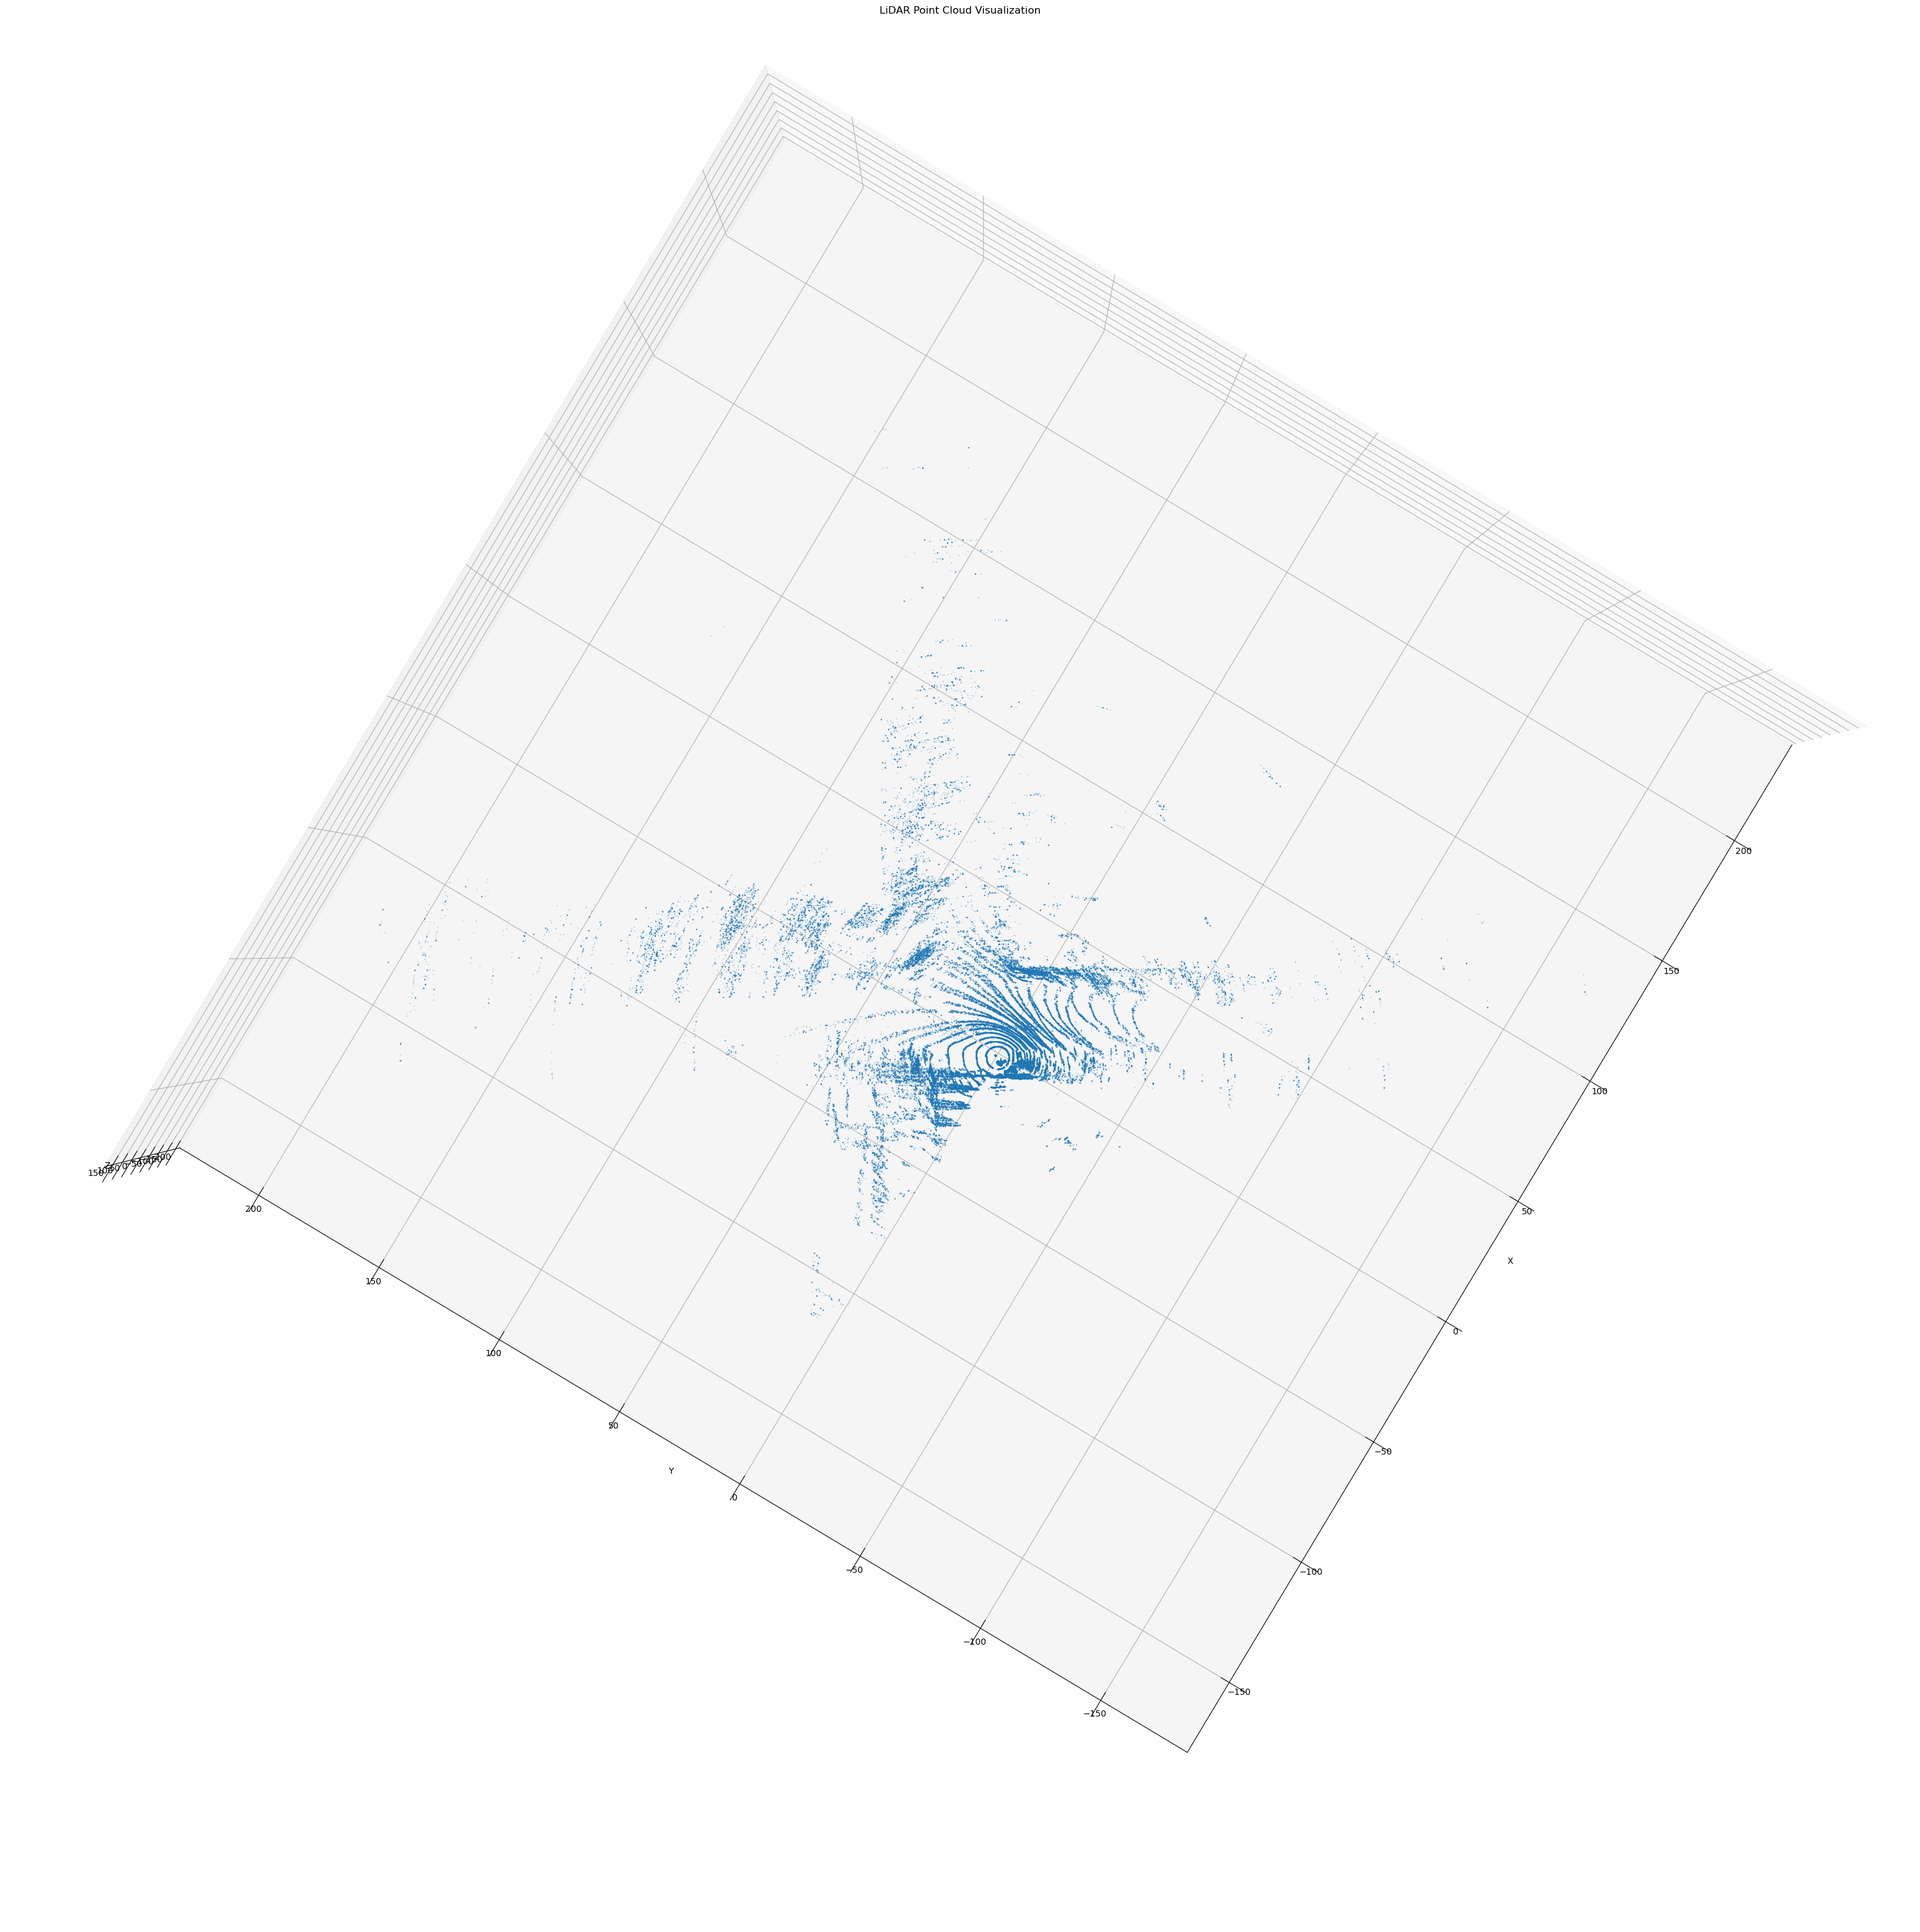

In [140]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot a subset if there are too many points
idx = np.random.choice(len(x_valid), size=100000, replace=False)
ax.scatter(x_valid[idx], y_valid[idx], z_valid[idx], s=0.1, marker=',')
# ax.scatter(x_valid, y_valid, z_valid, s=0.1)  # Adjust 's' for point size

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('LiDAR Point Cloud Visualization')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210)

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

## Test filter on frame

## Run the inference time test

## Save filtered data for inference tests